In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from time import perf_counter
from itertools import combinations, product
from sortedcontainers import SortedSet
import itertools
import copy

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def random_search(distance_matrix):
    n = len(distance_matrix)
    
    solution = list(range(n))
    np.random.shuffle(solution)
    
    return solution[:(n//2)]



def get_distance_matrix(df):
    coords = df[['x', 'y']].to_numpy()
    
    distance_matrix = np.round(squareform(pdist(coords, 'euclidean')))
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix



def get_total_cost(solution, distance_matrix, costs):
    total_cost = 0
    
    for i in range(len(solution)-1):
        total_cost += distance_matrix[solution[i], solution[i+1]] + costs[solution[i+1]]
        
    total_cost += distance_matrix[solution[-1], solution[0]] + costs[solution[0]]
        
    return total_cost

In [3]:
def compute_inter_move_delta(solution, distance_matrix, costs, idx, new_node):
    n = len(solution)
    new_solution = solution.copy()
    old_node = solution[idx]

    new = (costs[new_node] +
            distance_matrix[new_solution[idx-1], new_node] +
            distance_matrix[new_node, new_solution[(idx+1)%n]])

    old = (costs[old_node] +
             distance_matrix[new_solution[idx-1], old_node] +
             distance_matrix[old_node, new_solution[(idx+1)%n]])

    delta = new - old
    new_solution[idx] = new_node

    return new_solution, delta

In [4]:
######## DON'T REMOVE

# def compute_intra_move_delta(solution, distance_matrix, indices, backward=False):
#     n = len(solution)
#     new_solution = solution.copy()
#     i, j = indices
    
#     if i >= j: raise Exception('Wrong indeces, i >= j')
#     if j >= n: raise Exception('Wrong indeces, j >= n')
    
#     if backward:
#         if (i == 0 and j in (n-1, n-2)) or (j == n-1 and i in (0, 1)):
#             return new_solution, 0
#         new = distance_matrix[new_solution[i], new_solution[(j+1)%n]] + distance_matrix[new_solution[j], new_solution[i-1]]
#         old = distance_matrix[new_solution[i-1], new_solution[i]] + distance_matrix[new_solution[j], new_solution[(j+1)%n]]
#     else:
#         if j - i in (1, 2):
#             return new_solution, 0
#         new = distance_matrix[new_solution[i], new_solution[j-1]] + distance_matrix[new_solution[i+1], new_solution[j]]
#         old = distance_matrix[new_solution[i], new_solution[i+1]] + distance_matrix[new_solution[j-1], new_solution[j]]
        
#     delta = new - old
    
#     if backward:
#         new_solution = np.roll(np.concatenate((np.flip(new_solution[j+1:]), new_solution[i:j+1], np.flip(new_solution[:i]))), i-(n-1-j))
#     else:
#         new_solution = np.concatenate((new_solution[:i+1], np.flip(new_solution[i+1:j]), new_solution[j:]))

#     return new_solution.astype(int), delta




# def compute_intra_move_delta(solution, distance_matrix, indices, backward=False):
#     n = len(solution)
#     new_solution = solution.copy()
#     i, j = indices

#     if i >= j:
#         return new_solution, 0
    
#     if (i+1)%n == j%n  or (j+1)%n == i%n:
#         return new_solution, 0
    
#     if backward:
#         new = distance_matrix[new_solution[i-1], new_solution[j-1]] + distance_matrix[new_solution[i], new_solution[j]]
#         old = distance_matrix[new_solution[i-1], new_solution[i]] + distance_matrix[new_solution[j-1], new_solution[j]]
#     else:
#         new = distance_matrix[new_solution[i], new_solution[j]] + distance_matrix[new_solution[i+1], new_solution[(j+1)%n]]
#         old = distance_matrix[new_solution[i], new_solution[i+1]] + distance_matrix[new_solution[j], new_solution[(j+1)%n]]
        
#     delta = new - old
    
#     if backward:
#         new_solution = np.concatenate(( new_solution[:i], np.flip(new_solution[i:j]), new_solution[j:] ))
#     else:
#         new_solution = np.concatenate(( new_solution[:i+1], np.flip(new_solution[i+1:j+1]), new_solution[j+1:] ))

#     return list(new_solution.astype(int)), delta

In [5]:
def compute_intra_move_delta(solution, distance_matrix, indices, backward=False):
    n = len(solution)
    i, j = indices

    if i >= j or (i + 1) % n == j % n or (j + 1) % n == i % n:
        return solution.copy(), 0

    start, end = (i, j) if backward else (i + 1, j + 1)

    new = distance_matrix[solution[start - 1], solution[end - 1]] + distance_matrix[solution[start], solution[end % n]]
    old = distance_matrix[solution[start - 1], solution[start]] + distance_matrix[solution[end - 1], solution[end % n]]
    delta = new - old

    new_solution = solution[:start] + solution[start:end][::-1] + solution[end:]
    return new_solution, delta

In [6]:
def make_move(solution, move, distance_matrix, costs, solution_set, outer_nodes_set):
    nodes, _, move_type = move

    if move_type in ("intra_False", "intra_True"):
        node1_idx = solution.index(nodes[0])
        node2_idx = solution.index(nodes[1])
        indices = (node1_idx, node2_idx)
        backward = (move_type == "intra_True")
        new_solution, _ = compute_intra_move_delta(solution, distance_matrix, indices, backward)
        return new_solution

    if move_type.startswith("inter"):
        node_inner_idx = solution.index(nodes[1])
        new_node = nodes[0]
        new_solution, _ = compute_inter_move_delta(solution, distance_matrix, costs, node_inner_idx, new_node)
        solution_set.remove(nodes[1])
        solution_set.add(new_node)
        outer_nodes_set.remove(new_node)
        outer_nodes_set.add(nodes[1])
        return new_solution

    raise ValueError(f"Wrong move type: {move_type}")

In [7]:
def is_edge_valid(edge_nodes, solution, solution_set):
    if all(node in solution_set for node in edge_nodes):
        idx_first_node, idx_second_node = solution.index(edge_nodes[0]), solution.index(edge_nodes[1])
        edge_present = abs(idx_first_node - idx_second_node) == 1
        correct_order = idx_first_node + 1 == idx_second_node
        return edge_present, correct_order
    return False, False




def check_move_validity(solution, move, solution_set):
    move_nodes, adjacent_nodes, move_type = move

    def validate_edges(first_edge, second_edge):
        exists_first, order_correct_first = is_edge_valid(first_edge, solution, solution_set)
        exists_second, order_correct_second = is_edge_valid(second_edge, solution, solution_set)
        if exists_first and exists_second:
            return (order_correct_first == order_correct_second), (order_correct_first != order_correct_second)
        return False, False

    if move_type == 'inter':
        external_node, internal_node = move_nodes
        if external_node not in solution_set and internal_node in solution_set:
            adjacent_node_prev, adjacent_node_next = adjacent_nodes
            return validate_edges((adjacent_node_prev, internal_node), (internal_node, adjacent_node_next))

    elif move_type in ('intra_False', 'intra_True'):
        node_pair_1, node_pair_2 = (move_nodes[0], adjacent_nodes[0]), (move_nodes[1], adjacent_nodes[1])
        if move_type == 'intra_True':
            node_pair_1, node_pair_2 = node_pair_1[::-1], node_pair_2[::-1]
        return validate_edges(node_pair_1, node_pair_2)

    return False, False

In [8]:
def steepest_local_search_deltas(solution, distance_matrix, costs):
    solution = solution[:]
    # LM = dict()   # {move: delta} -> { (((node1, node2), (adjasent_node1, adjasent_node2), move_type)): delta}
    LM = SortedSet()
    n, N = len(solution), len(distance_matrix)
    solution_set = set(solution)
    outer_nodes_set = set(range(N)) - solution_set
        
    if n*2 != N: raise Exception('Solution size not half of all nodes')
    
    
    improved = True
    while improved:
        # if set(solution) != solution_set: raise Exception('Solution set not consistent with solutoin')
        # if len(solution_set & outer_nodes_set) > 0: raise Exception('Solution set and outer nodes set have common values')
        # if solution_set | outer_nodes_set != set(range(N)): raise Exception('Lost nodes in sets')
        
        improved = False
        # outer_nodes = list(set(range(N)) - set(solution))
        
        # inter
        for outer_node, inner_node_idx in product(outer_nodes_set, range(n)):
            move_type = 'inter'
            nodes = (outer_node, solution[inner_node_idx])
            adjasent_nodes = (solution[inner_node_idx-1], solution[(inner_node_idx+1)%n])
            key = (nodes, adjasent_nodes, move_type)
            # if key not in LM:
            # if (delta, key) not in LM:
            _, delta = compute_inter_move_delta(solution, distance_matrix, costs, inner_node_idx, outer_node)
            if delta < 0:
                # LM[key] = delta
                LM.add((delta, key))
        
        # intra
        for i, j in combinations(range(n), 2):
            # forward
            move_type = 'intra_False'
            nodes = (solution[i], solution[j])
            adjasent_nodes = (solution[i+1], solution[(j+1)%n])
            key = (nodes, adjasent_nodes, move_type)

            # if (delta, key) not in LM:
            _, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), False)
            if delta < 0:
                # LM[key] = delta
                LM.add((delta, key))
                    
            # backward
            move_type = 'intra_True'
            nodes = (solution[i], solution[j])
            adjasent_nodes = (solution[i-1], solution[j-1])
            key = (nodes, adjasent_nodes, move_type)
            # if (delta, key) not in LM:
            _, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), True)
            if delta < 0:
                # LM[key] = delta
                LM.add((delta, key))
                    
                    
        # loop over LM
        # LM_items = sorted(LM.items(), key=lambda x: x[1])
        for delta, move in LM:
            applicable, stored = check_move_validity(solution, move, solution_set)
            
            if applicable:
                improved = True
                solution = make_move(solution, move, distance_matrix, costs, solution_set, outer_nodes_set)
            
            if not stored:
                # del LM[move_tuple]
                LM.remove((delta, move))
                
            if improved:
                break
            
    return solution

In [9]:
# df = pd.read_csv('../data/TSPA.csv', names=['x', 'y', 'cost'], sep=';')
# distance_matrix = get_distance_matrix(df)
# costs = df.cost.to_numpy()
# solution = random_search(distance_matrix)

In [10]:
# get_total_cost(solution, distance_matrix, costs)

In [11]:
# new_solution = steepest_local_search_deltas(solution, distance_matrix, costs)

In [12]:
# get_total_cost(new_solution, distance_matrix, costs)

In [13]:
columns = ["Algorithm", "TSPA", "TSPB", "TSPC", "TSPD"]
cost_df = pd.DataFrame(columns=columns)
time_df = pd.DataFrame(columns=columns)
best_solutions = {}

instances = ['TSPA', 'TSPB', 'TSPC', 'TSPD']
path = "../data/"

algo_name = 'Steepest-PreviousDeltas-Random'
new_row = pd.DataFrame({columns[0]: algo_name}, index=[0])
cost_df = pd.concat([cost_df, new_row], ignore_index=True)
time_df = pd.concat([time_df, new_row], ignore_index=True)
best_solutions_tmp = {}

for instance in instances:
    file_name = f'{path}{instance}.csv'
    df = pd.read_csv(file_name, names=['x', 'y', 'cost'], sep=';')
    distance_matrix = get_distance_matrix(df)
    costs = df.cost.to_numpy()
    total_costs, solutions, times = list(), list(), list()
    print(algo_name, instance)
    for i in range(200):
        print(i)
        solution = random_search(distance_matrix)
        start_time = perf_counter()
        solution = steepest_local_search_deltas(solution, distance_matrix, costs)
        total_cost = get_total_cost(solution, distance_matrix, costs)
        end_time = perf_counter()
        total_costs.append(total_cost)
        solutions.append(solution)
        times.append(round(end_time - start_time, 3))
    best_solution_idx = np.argmin(total_costs)
    best_solutions_tmp[file_name] = solutions[best_solution_idx]
    cost_df.at[cost_df.index[-1], instance] = f'{np.mean(total_costs)} ({np.min(total_costs)} - {np.max(total_costs)})'
    time_df.at[time_df.index[-1], instance] = f'{round(np.mean(times), 3)} ({np.min(times)} - {np.max(times)})'
    print(f'{np.mean(total_costs)} ({np.min(total_costs)} - {np.max(total_costs)})')
    print(f'{np.mean(times)} ({np.min(times)} - {np.max(times)})')
    print(solutions[best_solution_idx])
    display(cost_df)
    display(time_df)
best_solutions[algo_name] = best_solutions_tmp

Steepest-PreviousDeltas-Random TSPA
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
79913.365 (76798.0 - 87582.0)
6.517345000000001 (5.292 - 7.677)
[68, 66, 98, 156, 6, 141, 87, 144, 154, 81, 171, 117, 22, 55, 36, 195, 53, 15, 108, 180, 32, 62, 163, 74, 113, 181, 25, 61, 71, 20, 64, 185, 96, 27, 147, 59, 143, 159, 132, 128, 164, 178, 19, 69, 0, 149, 50, 43

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,79913.365 (76798.0 - 87582.0),NaN,NaN,NaN


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,6.517 (5.292 - 7.677),NaN,NaN,NaN


Steepest-PreviousDeltas-Random TSPB
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
73141.7 (68884.0 - 78988.0)
6.52279 (5.425 - 8.05)
[122, 92, 66, 169, 0, 57, 99, 43, 50, 152, 112, 154, 25, 36, 165, 37, 137, 88, 55, 4, 153, 180, 80, 157, 145, 79, 136, 170, 189, 181, 147, 159, 64, 129, 89, 58, 85, 166, 71, 119, 59, 12, 107, 139, 44, 162, 114, 67, 150, 117

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,79913.365 (76798.0 - 87582.0),73141.7 (68884.0 - 78988.0),NaN,NaN


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,6.517 (5.292 - 7.677),6.523 (5.425 - 8.05),NaN,NaN


Steepest-PreviousDeltas-Random TSPC
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
53064.8 (49346.0 - 57601.0)
6.447629999999999 (5.265 - 7.948)
[93, 62, 32, 180, 81, 154, 171, 21, 194, 79, 87, 144, 141, 6, 156, 66, 98, 190, 72, 12, 94, 89, 42, 111, 14, 31, 80, 124, 123, 8, 110, 169, 95, 112, 51, 135, 134, 119, 130, 92, 48, 106, 160, 11, 152, 1, 177, 75, 

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,79913.365 (76798.0 - 87582.0),73141.7 (68884.0 - 78988.0),53064.8 (49346.0 - 57601.0),NaN


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,6.517 (5.292 - 7.677),6.523 (5.425 - 8.05),6.448 (5.265 - 7.948),NaN


Steepest-PreviousDeltas-Random TSPD
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
49794.255 (46581.0 - 55387.0)
6.485025 (5.131 - 7.811)
[163, 182, 2, 133, 5, 128, 34, 183, 197, 31, 101, 38, 103, 121, 24, 127, 179, 143, 122, 66, 169, 0, 57, 99, 43, 50, 154, 25, 36, 165, 37, 137, 88, 55, 4, 153, 80, 157, 145, 135, 198, 190, 19, 33, 136, 61, 73, 185, 81, 2

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,79913.365 (76798.0 - 87582.0),73141.7 (68884.0 - 78988.0),53064.8 (49346.0 - 57601.0),49794.255 (46581.0 - 55387.0)


,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,6.517 (5.292 - 7.677),6.523 (5.425 - 8.05),6.448 (5.265 - 7.948),6.485 (5.131 - 7.811)


In [18]:
cost_df.to_csv('costs.csv')

In [19]:
time_df.to_csv('times.csv')

In [16]:
display(cost_df)

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,79913.365 (76798.0 - 87582.0),73141.7 (68884.0 - 78988.0),53064.8 (49346.0 - 57601.0),49794.255 (46581.0 - 55387.0)


In [17]:
display(time_df)

,Algorithm,TSPA,TSPB,TSPC,TSPD
0,Steepest-PreviousDeltas-Random,6.517 (5.292 - 7.677),6.523 (5.425 - 8.05),6.448 (5.265 - 7.948),6.485 (5.131 - 7.811)


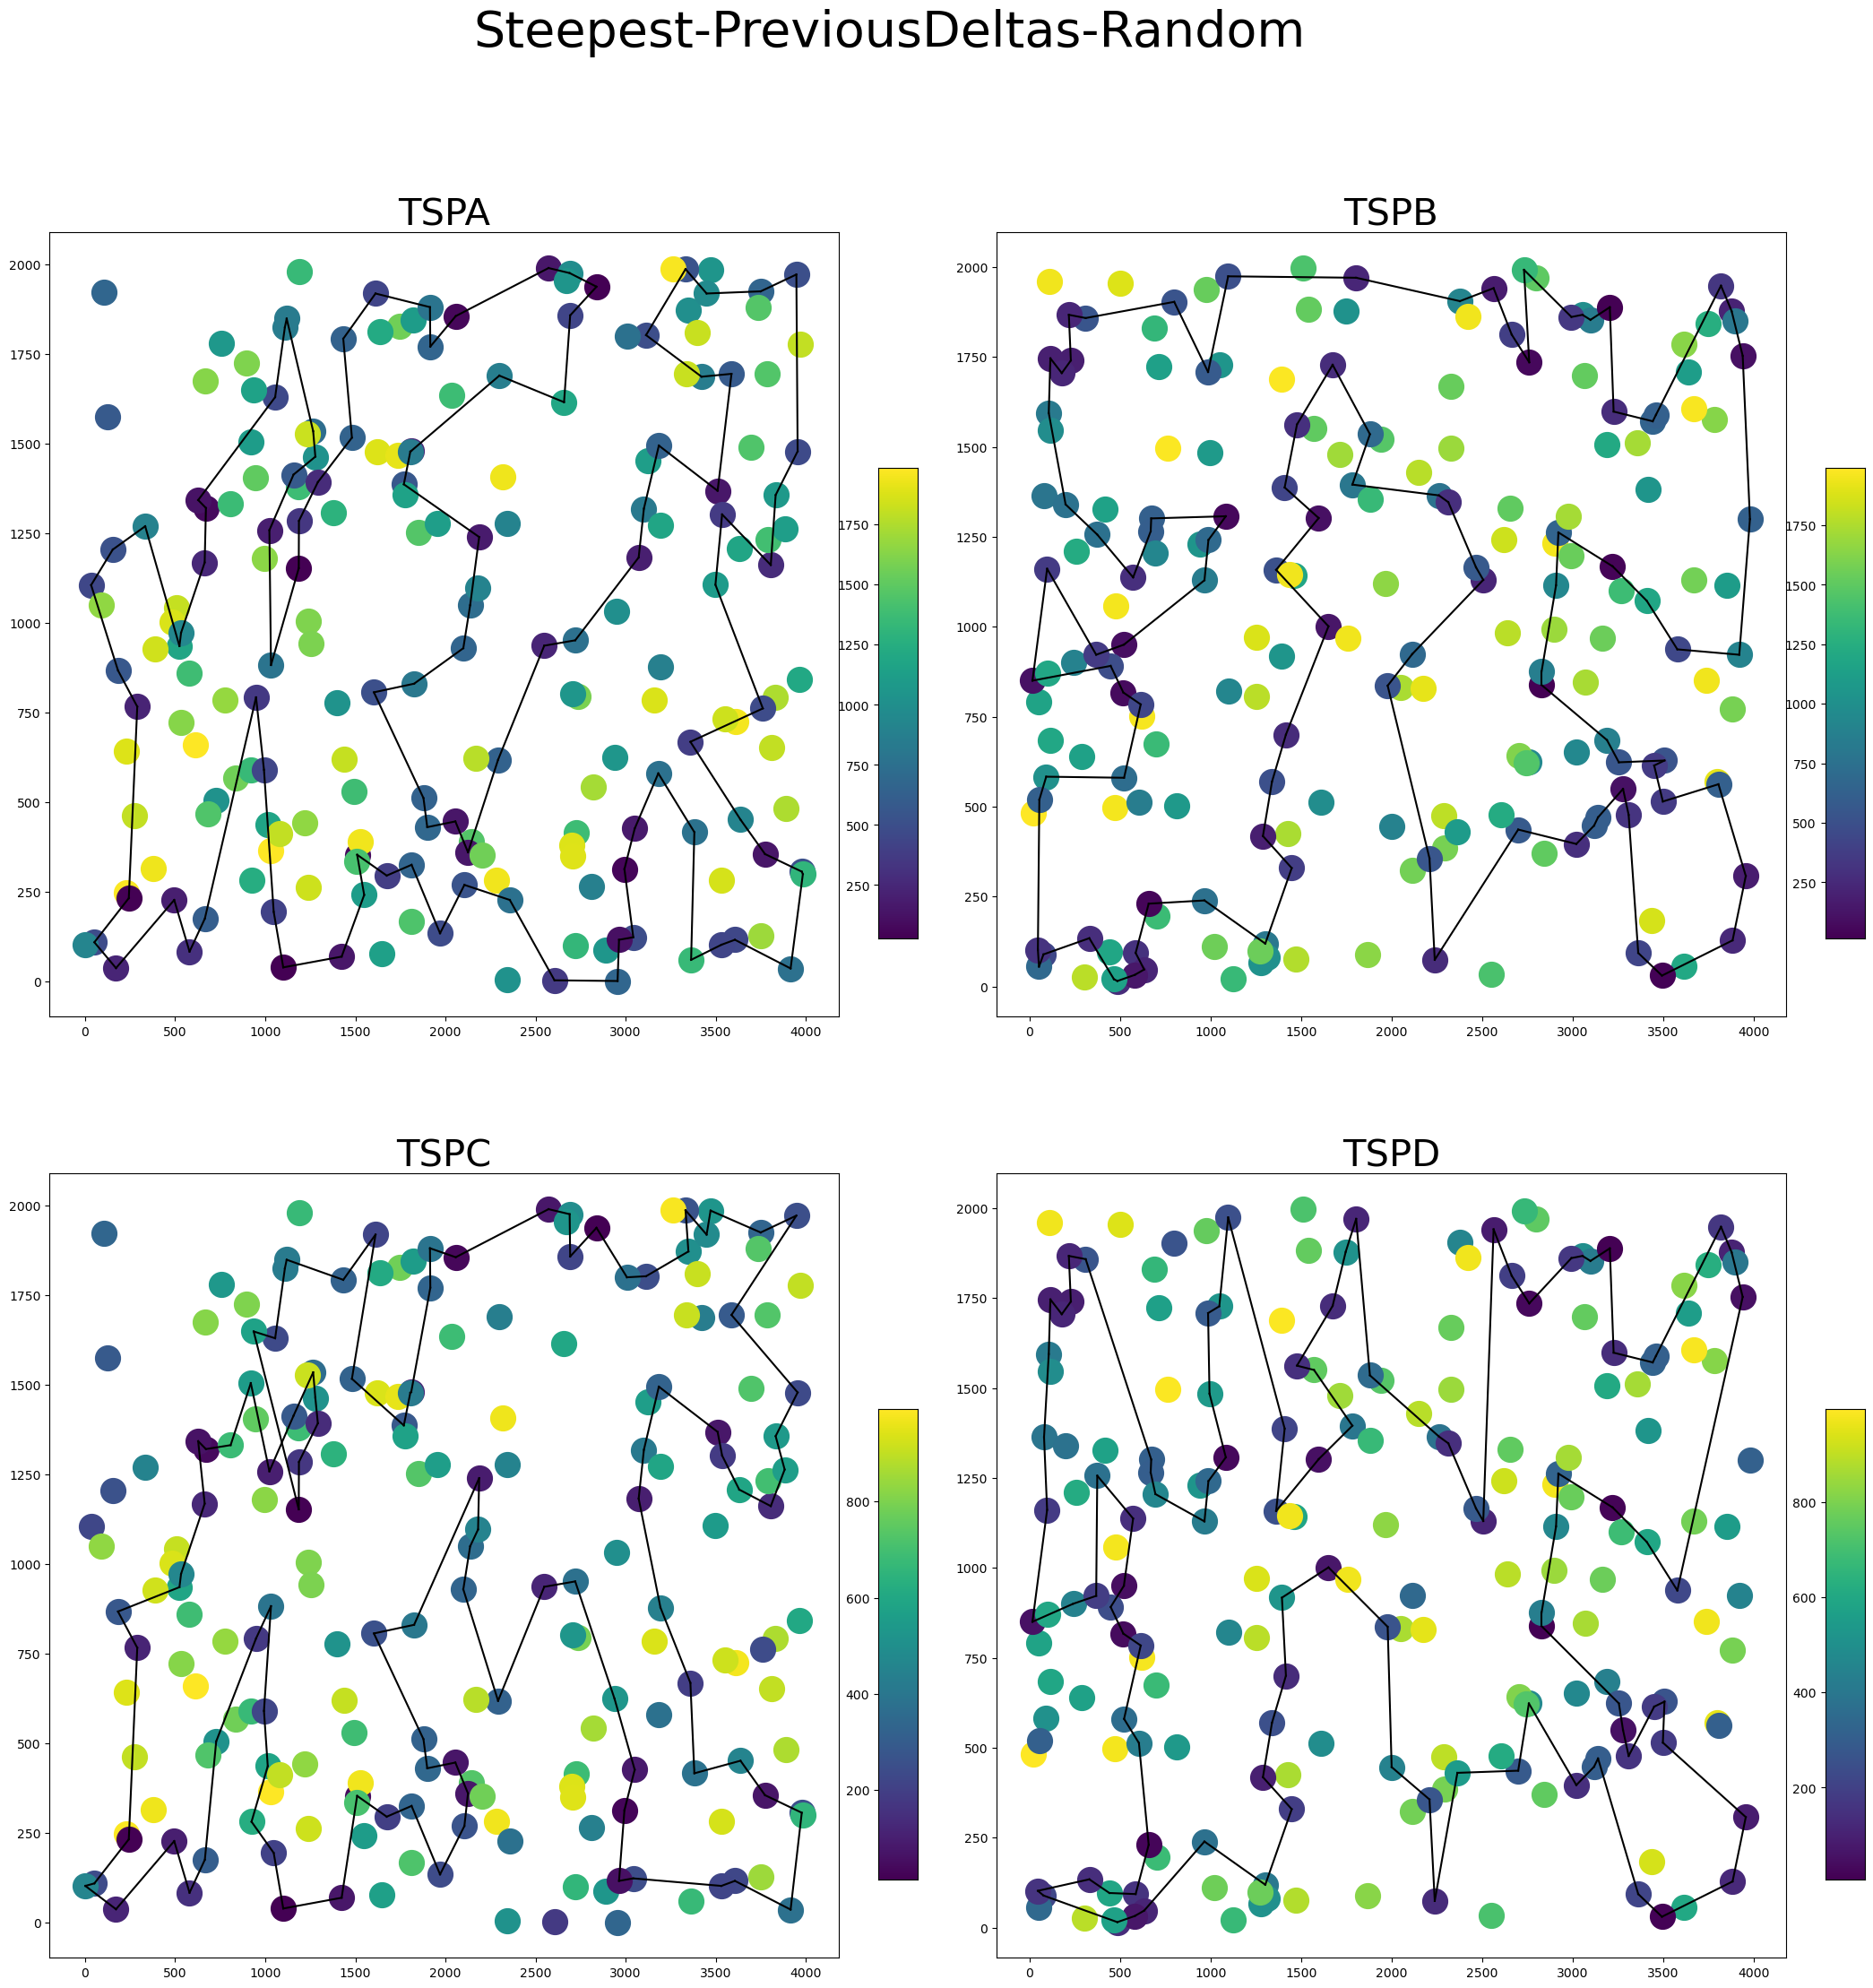

In [14]:
for algo in best_solutions:
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(algo, fontsize=40)
    for instance in best_solutions[algo]:
        solution = best_solutions[algo][instance]
        df = pd.read_csv(instance, names=['x', 'y', 'cost'], sep=';')
        weights = df['cost']
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
        ax[idx].set_title(instance.replace('../data/', '').replace('.csv', ''), fontsize=30)
        for i in range(len(df)):
            x, y, cost = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['cost']
            ax[idx].plot(x, y, "o", markersize=20, color=cmap(norm(cost)))
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        axins.xaxis.set_visible(False)
        
        idx += 1
        
    plt.savefig(f'./plots/{algo}.png', dpi=300)
    plt.show()